## Load File

In [1]:
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import imageio
import os
import scipy.integrate as integrate
from tqdm import tqdm  # For progress bars

filename = 'B00_run11.nc' #remember.nc at the end
ds = xr.open_dataset(filename, engine = 'netcdf4', decode_times=False)


# Non-dimensionalising timescale
g = 9.81
f = 1e-4
L = 10*1000
H_front = 100

# Rescale time: convert seconds to non-dimensional time = f * t
# Ensure 'time' is in seconds (if it's in days, convert to seconds first)
time = ds.time.values
nondim_time =  time * f 


# Add non-dimensional time to dataset for convenience
ds = ds.assign_coords(nondim_time=("time", nondim_time))


## Buoyancy Animation

In [12]:
# contours working

b = ds['b'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(b.quantile(0.05)), float(b.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, b_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='Buoyancy (m/s²)')  
    
    
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
              levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Buoyancy plot",
           xlabel="x (km)", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    ax.set_xlim(-100, 100)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_buoyancy.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 102/102 [00:24<00:00,  4.21it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_20168\1077272558.py:51: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1046, 586) to (1056, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Frontogenesis Visualisation (M^2)

In [ ]:
# contours working

b = ds['b'].load()  # Load only after preprocessing
M_squared = ds['M_squared'].load()


# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(M_squared.quantile(0.05)), float(M_squared.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    M_squared_data = M_squared.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, M_squared_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='M_squared or db/dx')  
    
    
    
    #ax.contour(x_km, ds.z_aac.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, M_squared plot",
           xlabel="x (km)", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    ax.set_xlim(-100, 100)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_buoyancy.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 54/54 [00:13<00:00,  3.94it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_5828\4017835063.py:54: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1001, 586) to (1008, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


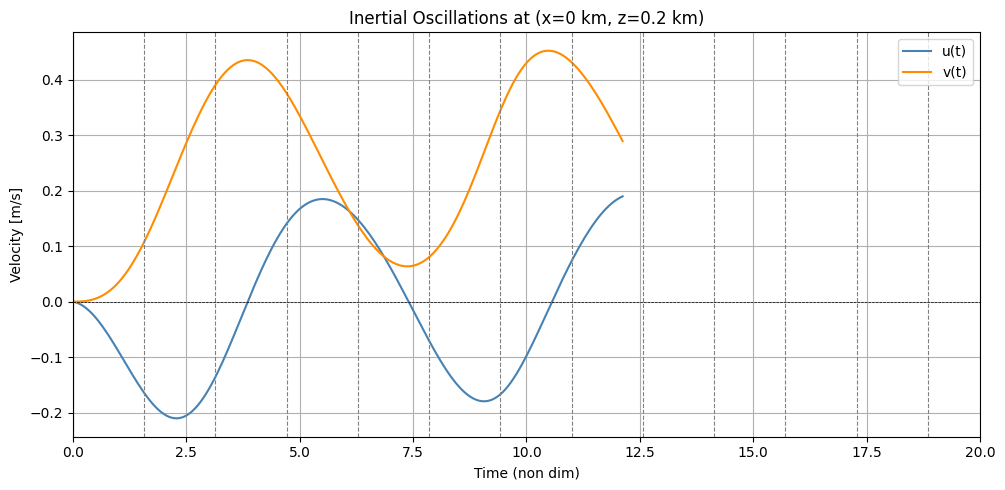

In [2]:
# === Choose fixed (x, z) location ===
x_target = 0       # center of the front
z_target = -ds.z_aac.values.max() / 2  # mid-depth

# === Find nearest grid indices ===
x_index = np.argmin(np.abs(ds.x_caa.values - x_target))
z_index = np.argmin(np.abs(ds.z_aac.values - z_target))


# === Extract time series ===
time = ds.time.values # convert from nanoseconds to hours (if needed)
u_t = ds.u[:, z_index, x_index].values
v_t = ds.v[:, z_index, x_index].values
w_t = ds.w[:, z_index, x_index].values

# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(nondim_time, u_t, label='u(t)', color='steelblue')
plt.plot(nondim_time, v_t, label='v(t)', color='darkorange')
#plt.plot(nondim_time, w_t, label='v(t)', color='darkred')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.title(f'Inertial Oscillations at (x={x_target} km, z={z_target:.1f} km)')
plt.xlabel('Time (non dim)')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0,20)

for t in range(0,20):
    plt.axvline(x= t*np.pi/2, color='gray', linestyle='--', linewidth=0.8)
    #plt.text(t, 0, f'{t}π/2', ha='center', va='top', fontsize=10, rotation=90)
plt.show()



## Geostrophic and ageostrophic flow

In [11]:
# Data arrays
dbdX = ds.dbdX.values  # shape: (time, z, x)
z_vals = ds.z_aac.values  # shape: (z,)
time_vals = ds.nondim_time.values  # shape: (time,)
# Allocate v_g with same shape as dbdX

v_g = -(g / f) * ds.dbdX * (H_front / 2 - ds.z_aac)

#v_a = ds.v - v_g
v_g = -(g / f) * ds.dbdX * (H_front / 2 - ds.z_aac)

v_g = v_g.isel(x_faa=slice(None, -1))

print(v_g.shape, ds.v.shape)

#v_a = ds.v - v_g
v_g = v_g.rename({'x_faa': 'x_caa'})

v_a = ds.v - v_g

v_a.shape


(203, 160, 500) (203, 160, 500)


(203, 160, 0)

In [2]:
import xarray as xr
import numpy as np

# Parameters (adjust to your values)
g = 9.81
f = 1e-4
H_front = 100.0  # Your frontal height scale

# Compute v_g in chunks
v_g = - (g / f) * ds.dbdX * (H_front / 2 - ds.z_aaf)

# Compute ageostrophic velocity (also chunked)
#v_a = ds.v - v_g

v_g.shape


: 

In [11]:
v_a.shape
v_a

<xarray.DataArray (time: 203, z_aac: 160, x_caa: 500, x_faa: 501)> Size: 33GB
dask.array<sub, shape=(203, 160, 500, 501), dtype=float32, chunksize=(10, 160, 500, 501), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 2kB 00:00:00 00:10:00 ... 1 days 09:40:00
  * x_caa    (x_caa) float32 2kB -3.194e+05 -3.181e+05 ... 3.181e+05 3.194e+05
  * z_aac    (z_aac) float32 640B -99.69 -99.06 -98.44 ... -0.9375 -0.3125
  * x_faa    (x_faa) float32 2kB -3.2e+05 -3.187e+05 ... 3.187e+05 3.2e+05

  0%|          | 0/102 [00:00<?, ?it/s]


TypeError: Length of x (501) must match number of columns in z (500)

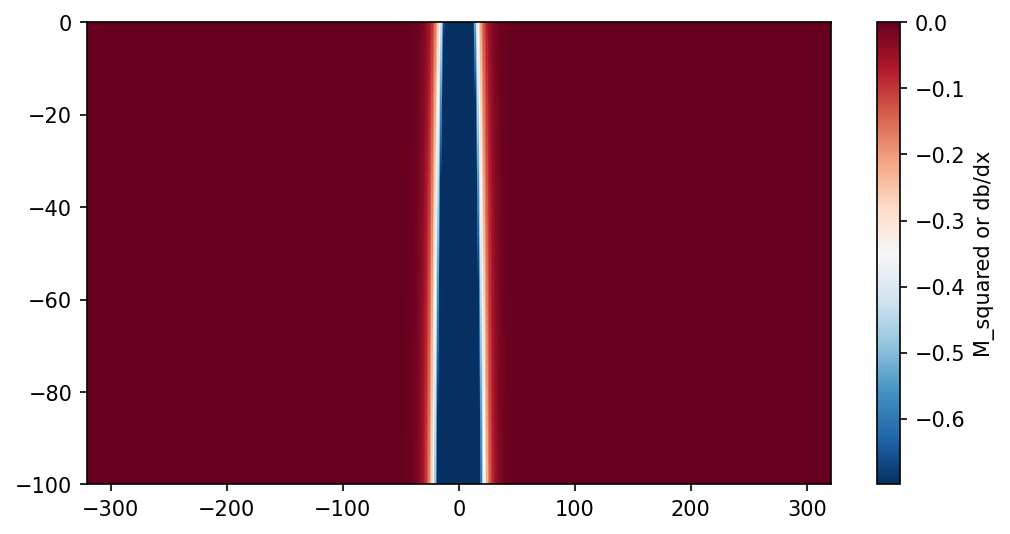

In [ ]:
# contours working

b = ds['b'].load()  # Load only after preprocessing


# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(v_g.quantile(0.05)), float(v_g.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    v_g_data = v_g.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, v_g_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='M_squared or db/dx')  
    
    
    
    #ax.contour(x_km, ds.z_aac.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, v_g plot",
           xlabel="x (km)", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    ax.set_xlim(-100, 100)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_geostrophic_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

In [9]:
# contours working

b = ds['b'].load()  # Load only after preprocessing


# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(v_a.quantile(0.05)), float(v_a.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    v_a_data = v_a.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, v_a_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='M_squared or db/dx')  
    
    
    
    #ax.contour(x_km, ds.z_aac.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, v_g plot",
           xlabel="x (km)", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    ax.set_xlim(-100, 100)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_geostrophic_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

MemoryError: Unable to allocate 1.49 GiB for an array with shape (10, 160, 500, 501) and data type float32

In [21]:
v_g

<xarray.DataArray 'v_g' (time: 203, z_aac: 160, x_caa: 500)> Size: 65MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(203, 160, 500), dtype=float32)
Coordinates:
  * time         (time) float64 2kB 0.0 600.0 1.2e+03 ... 1.206e+05 1.212e+05
  * x_caa        (x_caa) float32 2kB -3.194e+05 -3.181e+05 ... 3.194e+05
  * z_aac        (z_aac) float32 640B -99.69 -99.06 -98.44 ... -0.9375 -0.3125
    nondim_time  (time) float64 2kB 0.0 0.06 0.12 0.18 ... 12.0 12.06 12.12

## Richardson number

In [48]:
Ri = ds['Ri'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(b.quantile(0.05)), float(b.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    Ri_data = Ri.isel(time=i).values
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, Ri_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='Ri')  
    
    
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Ri number plot",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    #ax.set_xlim(-1,1)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_Ri.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)


100%|██████████| 102/102 [00:24<00:00,  4.08it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_11492\1285258174.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1046, 586) to (1056, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
ds.Ri.shape


(21, 100, 500, 501)

## Along fron velocity (u)

In [ ]:
# contours not working

u = ds['u'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(u.quantile(0.05)), float(u.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    u_data = u.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, u_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
          #  levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Buoyancy plot",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_u.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 52/52 [00:26<00:00,  1.98it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_30368\2593955291.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1060, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Along jet velocity (v)

In [ ]:
# contours not working

v = ds['v'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(v.quantile(0.05)), float(v.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    v_data = v.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, v_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
          #  levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, along jet (v)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 52/52 [00:29<00:00,  1.79it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_30368\3530609042.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1060, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Vertical velocity (w)

In [ ]:
# contours not working

w = ds['w'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(w.quantile(0.05)), float(w.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    w_data = w.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, w_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
            levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, vertical (w)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_w.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 102/102 [00:57<00:00,  1.78it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_30368\692373657.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1060, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


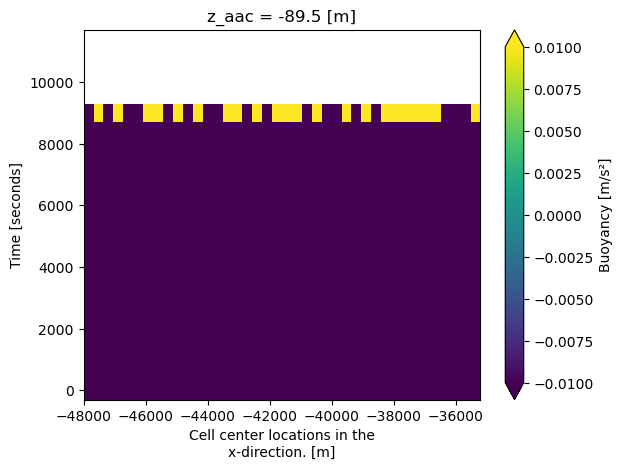

In [ ]:
ds.b[:20,10,100:140].plot(vmin = -0.01, vmax = 0.01)